# Task 5 : Image Compression using Matrix Factorisation [3 Marks]
You have an image patch of size (50x50) that you want to compress using matrix factorization. To do this, you'll split the patch $[N\times N]$ into two smaller matrices of size $[N\times r]$ and $[r\times N]$ using matrix factorization. Compute the compressed patch by multiplying these two matrices and compare the reconstructed image patch with the original patch. Compute the Root Mean Squared Error (RMSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed image patches.

- Test different values for the low-rank $r = [5, 10, 25, 50]$.
- Use Gradient Descent to learn the compressed matrices.
- Display the reconstructed image patches, keeping the original pixel values outside the patch unchanged, and use your compressed matrix for the patch to show how well the reconstruction works.
- Compute the RMSE and PSNR for each value of $r$.

Here is a reference set of patches that you can choose. You can chose an image of your liking and create patches. You can choose the image shown below as well. \
[3 Marks]

In [13]:
import torch
import torchvision

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from latexify import latexify, format_axes

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

from utils import factorize, metrics, random_patch

In [20]:
def plot_image_completion(img,
                          factors_list=[5, 10, 25, 50],
                          patch_size=50,
                          device=device):
    
    # Choose a random patch from the image
    patch, start_x, start_y = random_patch(img, patch_size)
    
    latexify()

    fig = plt.figure(figsize=(8, 20), dpi=300)
    gs = GridSpec(len(factors_list)+2, 2, figure=fig)

    ax_org = fig.add_subplot(gs[0, :])
    ax_org.imshow(img.permute(1,2,0).cpu().numpy())
    ax_org.set_title(f"Original image with Patch")
    ax_org.add_patch(plt.Rectangle((start_x, start_y), patch_size, patch_size, edgecolor='r', facecolor='none'))
    ax_org.axis("off")
    format_axes(ax_org)

    rmses = []
    psnrs = []
    for i, r in enumerate(factors_list):
        Wr, Hr, lossr = factorize(patch[0], r, device=device)
        Wg, Hg, lossg = factorize(patch[1], r, device=device)
        Wb, Hb, lossb = factorize(patch[2], r, device=device)

        compressed_patch = torch.clamp(torch.stack([torch.mm(Wr, Hr).detach(), torch.mm(Wg, Hg).detach(), torch.mm(Wb, Hb).detach()], dim=0), 0, 1)

        reconstructed_img = img.clone()
        reconstructed_img[:,start_y:start_y + patch_size, start_x:start_x + patch_size] = compressed_patch

        rmse, psnr = metrics(img, reconstructed_img)
        rmses.append(rmse.cpu().numpy())
        psnrs.append(psnr.cpu().numpy())

        ax_pr = fig.add_subplot(gs[i+1,:])
        ax_pr.set_title(f"r={r}, RMSE={rmse:.4f}, PSNR={psnr:.4f}")
        format_axes(ax_pr)

        # Plot compressed patch with metrics in the loop
        ax_p = fig.add_subplot(gs[i+1, 0])
        ax_p.imshow(compressed_patch.permute(1,2,0).cpu().numpy())
        ax_p.axis("off")
        format_axes(ax_p)

        # Plot reconstructed image with metrics in the loop
        ax_r = fig.add_subplot(gs[i+1, 1])
        ax_r.imshow(reconstructed_img.permute(1,2,0).cpu().numpy())
        ax_r.add_patch(plt.Rectangle((start_x, start_y), patch_size, patch_size, edgecolor='r', facecolor='none'))
        ax_r.axis("off")
        format_axes(ax_r)
        
    # Plot RMSE and PSNR vs r outside the loop
    axrmse = fig.add_subplot(gs[-1,0])
    axrmse.plot(factors_list, rmses, marker='o')
    axrmse.set_xlabel('r')
    axrmse.set_ylabel('RMSE')
    axrmse.set_title('RMSE vs r')
    format_axes(axrmse)
    axpsnr = fig.add_subplot(gs[-1,1])
    axpsnr.plot(factors_list, psnrs, marker='o')
    axpsnr.set_xlabel('r')
    axpsnr.set_ylabel('PSNR')
    axpsnr.set_title('PSNR vs r')
    format_axes(axpsnr)



    # Make the layout tight for better appearance
    plt.tight_layout()
    plt.show()

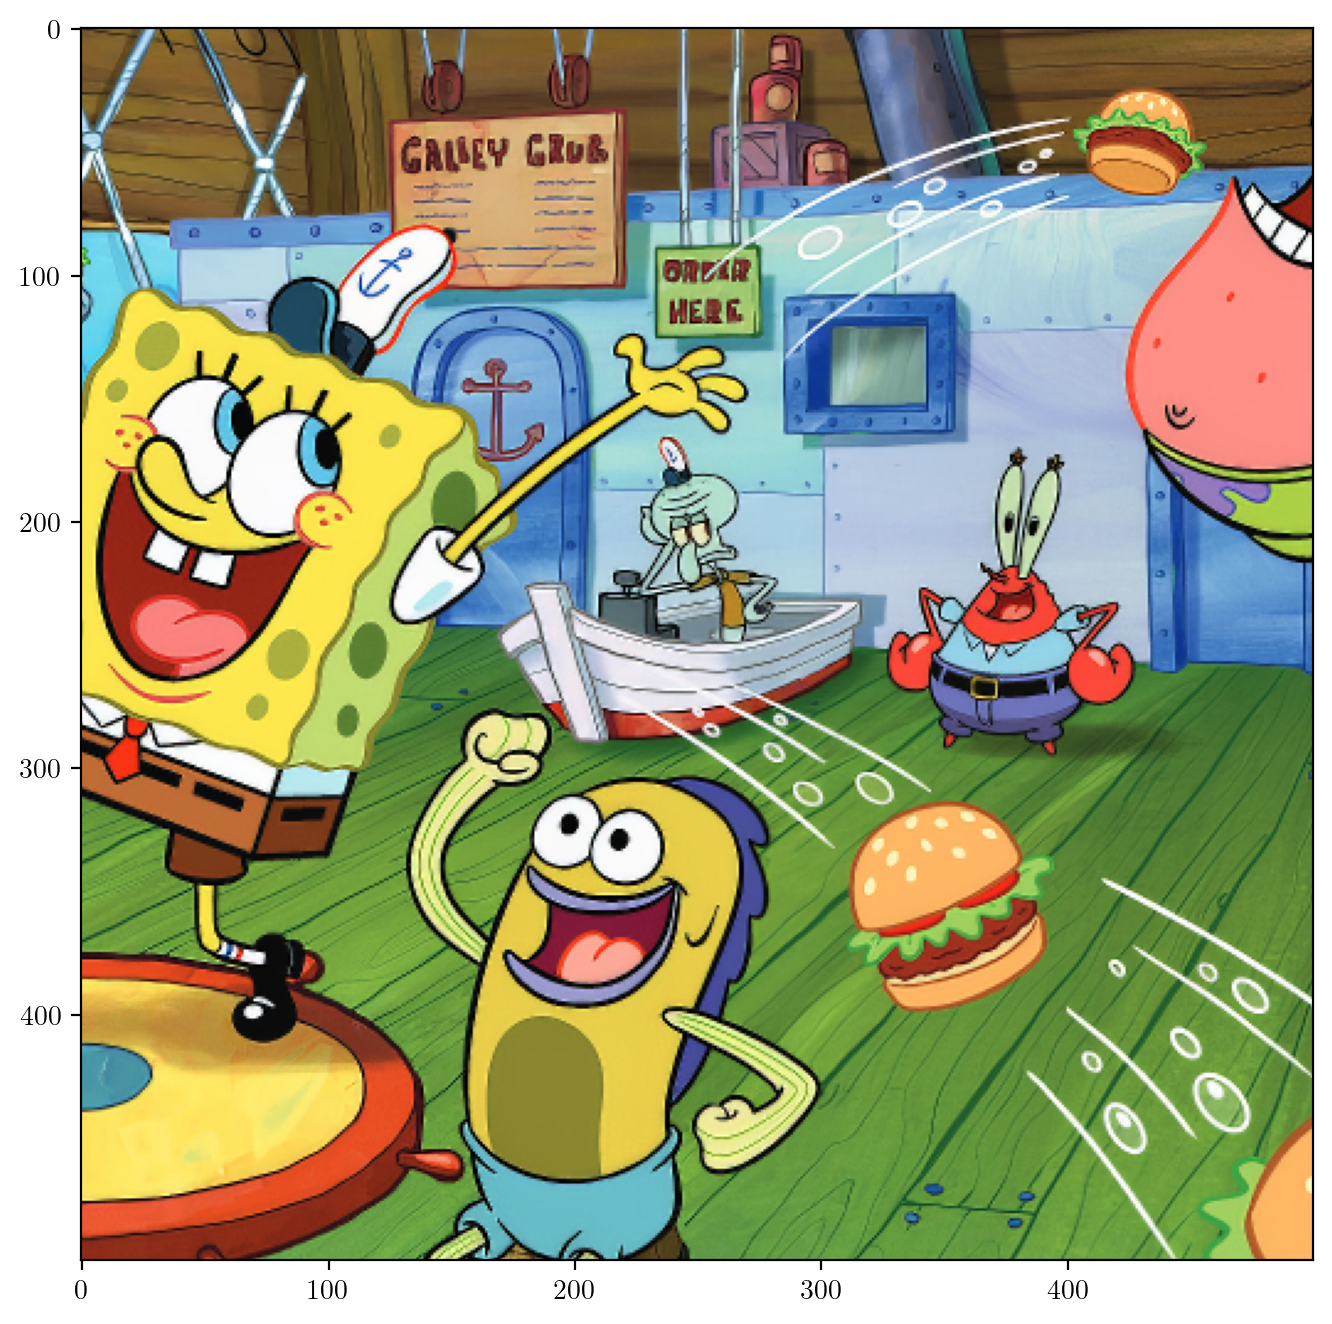

In [21]:
krustykrab = torchvision.io.read_image("images/krustykrab.png")
krustykrab = krustykrab.to(dtype=torch.float32, device=device)/255

transform = torchvision.transforms.CenterCrop((500, 500))

krustykrab = transform(krustykrab)

plt.figure(figsize=(12, 8))  
plt.imshow(krustykrab.permute(1,2,0).cpu().numpy())
plt.show()

In [22]:
plot_image_completion(krustykrab,
                          factors_list=[5, 10, 25, 50],
                          patch_size=50,
                          device=device)